In [1]:
import pandas as pd
from PIL import Image
import requests
from io import BytesIO
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.layers import Activation, Dense

In [2]:
def load_and_proccess_image(id):
  # Load image, then scale and shift pixel values to [-0.5, 0.5]
  id=str(id)
  for i in range(12-len(id)):
    id='0'+id
  img = Image.open('../input/coco2014/train2014/train2014/COCO_train2014_'+id+'.jpg')
  img=img.resize((64,64))
  im = img_to_array(img)
  return im / 255 - 0.5


## load

In [3]:
train=pd.read_csv('../input/qa-coco1/train_2.csv')

In [4]:
train.columns=['question','object','id']

In [5]:
train_question=train['question'].values
train_answer=train['object'].values
train_id=train['id'].values

In [6]:
train_answer=train_answer[:5000]
train_question=train_question[:5000]
train_id=train_id[:5000]

In [7]:
ims=[]
for i in range(len(train_id)):
  id=train_id[i]
  ims.append(load_and_proccess_image(id))


In [8]:
del_index=[]
for k in range(len(train_id)):
    if ims[k].shape!=(64,64,3):
        del_index.append(k)
        
import cv2
import numpy as np
for j in del_index:
    gray = ims[j]
    ims[j] = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)

In [9]:
all_answer=np.unique(train_answer)

In [10]:
train_X_ims = ims

In [11]:


from tensorflow.keras.utils import to_categorical

# Create model input images


# Create model outputs
train_answer_indices = [all_answer.tolist().index(a) for a in train_answer]

train_Y = to_categorical(train_answer_indices)



In [12]:
len(train_answer_indices)

5000

In [13]:

from tensorflow.keras.preprocessing.text import Tokenizer



# Fit tokenizer on the training questions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_question)

# Convert questions to BOW
train_X_seqs = tokenizer.texts_to_matrix(train_question)

# Model

In [14]:
#Creating the CNN model for image processing
from tensorflow.keras.layers import Multiply
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf

CNN_Input=tf.keras.layers.Input(shape=(64,64,3))
CNN_model=tf.keras.applications.vgg16.VGG16(input_shape=(64,64,3), include_top=False,weights='imagenet', input_tensor=CNN_Input,classifier_activation='softmax')(CNN_Input)
CNN_model=tf.keras.layers.GlobalAveragePooling2D()(CNN_model)


vocab_size = len(tokenizer.word_index) + 1
shape=(vocab_size)

#Creating the RNN model for text processing
RNN_model=tf.keras.models.Sequential()

RNN_Input=tf.keras.layers.Input(shape=vocab_size,name='text_input')
RNN_model=tf.keras.layers.Embedding (vocab_size,128)(RNN_Input)
RNN_model=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,stateful=False,return_sequences=True,recurrent_initializer='glorot_uniform'))(RNN_model)
RNN_model=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,stateful=False,return_sequences=True,recurrent_initializer='glorot_uniform'))(RNN_model)
RNN_model=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,stateful=False,return_sequences=False,recurrent_initializer='glorot_uniform'))(RNN_model)




58892288/58889256 [==============================] - 0s 0us/step


In [15]:
from tensorflow.keras.layers import Multiply
out = Multiply()([CNN_model, RNN_model])
out = Dense(32, activation='tanh')(out)
# num_answers will be defined below
out = Dense(len(all_answer), activation='softmax')(out)

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
model = Model(inputs=[CNN_Input, RNN_Input], outputs=out)
model.compile(
  Adam(lr=2e-4), # somewhat arbitrarily chosen
  loss='categorical_crossentropy',
  metrics=['accuracy'],)

In [17]:
import tensorflow as tf
train_X_ims=tf.stack(train_X_ims)

In [18]:


model.fit(
  # Reminder: train_X_seqs is from this post's BOW section
  [train_X_ims[:4500], train_X_seqs[:4500]],
  train_Y[:4500],
  validation_data=([train_X_ims[4500:], train_X_seqs[4500:]], train_Y[4500:]),
  shuffle=True,
  epochs=5,steps_per_epoch=25, validation_steps=25 # somewhat arbitrary, try more epochs if you have time!
)

Epoch 1/5
25/25 [==============================] - 86s 3s/step - loss: 2.2720 - accuracy: 0.1443 - val_loss: 2.1868 - val_accuracy: 0.2220
Epoch 2/5
25/25 [==============================] - 63s 3s/step - loss: 2.1283 - accuracy: 0.2518 - val_loss: 2.0031 - val_accuracy: 0.3180
Epoch 3/5
25/25 [==============================] - 63s 3s/step - loss: 1.9059 - accuracy: 0.3547 - val_loss: 1.8465 - val_accuracy: 0.4000
Epoch 4/5
25/25 [==============================] - 63s 3s/step - loss: 1.7018 - accuracy: 0.4375 - val_loss: 1.7594 - val_accuracy: 0.4420
Epoch 5/5
25/25 [==============================] - 63s 3s/step - loss: 1.5932 - accuracy: 0.4768 - val_loss: 1.7413 - val_accuracy: 0.4380


In [19]:
model.save('QA.h5')

# test

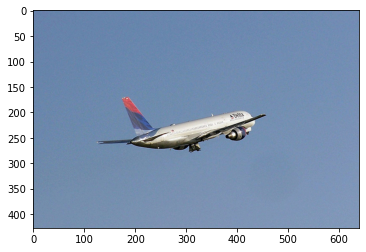

In [20]:
import matplotlib.pyplot as plt

id=str(train_id[22])
for i in range(12-len(id)):
    id='0'+id
img = Image.open('../input/coco2014/train2014/train2014/COCO_train2014_'+id+'.jpg')
plt.imshow(img)

img=img.resize((64,64))
im = img_to_array(img)
img=im / 255 - 0.5
img=[img]


img=tf.stack(img)





In [21]:
ques=['what is the color of plane']
ques=tokenizer.texts_to_matrix(ques)
print(all_answer[np.argmax(model.predict([img,ques],steps=1), axis=1)[0]])

blue
